In [1]:
import os
import shutil
from pathlib import Path

import jax.random as jr
import jax.numpy as jnp
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from cohlib.utils import pickle_open
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.observations import add0



In [2]:
def load_results(paths, alphas_sel, **kwargs):
    Lpaths = get_model_paths(paths, **kwargs)
    results = {}
    alphas = []
    for path in Lpaths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)
        alpha = cfg.obs.alpha
        if alphas_sel is not None:
            if alpha in alphas_sel:
                alphas.append(alpha)
        alphas = jnp.array(alphas)
    assert len(Lpaths) > 0
    if alphas.size == jnp.unique(alphas).size:

        for path in Lpaths:
            cfg_path = os.path.join(path, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)
            alpha = cfg.obs.alpha

            res = pickle_open(os.path.join(path, 'res.pickle'))
            res['cfg'] = cfg
            results[alpha] = res

    else:
        print('Duplicates found for alpha - returning empty dict.')

    return results

# def get_model_paths(paths, **kwargs):
#     sel_paths = []
#     for path in paths:
#         _dir = Path(path)
#         for i, exp in enumerate(_dir.glob('*')):
#             cfg_path = os.path.join(exp, '.hydra/config.yaml')
#             cfg = OmegaConf.load(cfg_path)
#             # print(cfg.obs.obs_type)

            # if cfg.latent.L == L:
            #     if cfg.model.emiters == emiters:
            #         if cfg.model.init == init:
            #             if cfg.model.scale_init == scale_init:
            #                 if supp is not None:
            #                     if 'support' in list(cfg.model.keys()):
            #                         if cfg.model.support == supp:
            #                                 sel_paths.append(exp)
            #                 else:
            #                     if 'support' not in list(cfg.model.keys()):
            #                         if cfg.model.emiters == emiters:
            #                             sel_paths.append(exp)
            #                     else:
            #                         if cfg.model.support == supp:
            #                                 sel_paths.append(exp)
    # print(f'{len(sel_paths)} results found meeting criteria.')
    # return sel_paths

In [3]:
def clean_dir(path):
    _dir = Path(path)
    for i, exp in enumerate(_dir.glob('*')):
        exp_path = Path(exp)
        contents = []
        for f in exp_path.glob('*'):
            contents.append(os.path.split(f)[1])
        if 'res.pickle' not in contents: 
            shutil.rmtree(exp_path)
            print('Removing unfinished experiment')

In [5]:
def get_model_paths(paths, **kwargs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)

            if cfg.obs.obs_type == 'pp_relu':
                if cfg.model.init == 'true-init':
                    if cfg.model.init_mod == 0.001:
                        if 'true_to_flat' in cfg.model:
                            if cfg.model.true_to_flat == 'target':
                                if cfg.model.scale_init == 1e4:
                                    if cfg.latent.scale == 1e4:
                                        if cfg.model.emiters == 100:
                                            sel_paths.append(exp)
    print(f'{len(sel_paths)} paths found meeting critera')
    return sel_paths

res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/pp_relu_obs/outputs/2024-09-03-inits']
for res_path in res_paths:
    clean_dir(res_path)


In [6]:
res1 = load_results(res_paths, alphas_sel=None)
# res1[100].keys()
res1.keys()


1 paths found meeting critera


dict_keys([200])

In [55]:
from cohlib.utils import gamma_root
from cohlib.jax.dists import sample_obs, cif_alpha_relu
res = res1[200]
cfg = res['cfg']

lcfg = cfg.latent
ocfg = cfg.obs
mcfg = cfg.model

flow = lcfg.freq_low
fhigh = lcfg.freq_high
sp_target = lcfg.scale_power_target
sp_offtarget = lcfg.scale_power_offtarget
gamma_path = os.path.join(gamma_root(), f"k2-full{flow}-{fhigh}-10-{sp_target}-{sp_offtarget}.pickle")
gamma_load = pickle_open(gamma_path)

gamma_full = gamma_load['gamma']
gamma_full = gamma_full * lcfg.scale
freqs = gamma_load['freqs']
N = freqs.size
nz = gamma_load['nonzero_inds']
nz_target = jnp.array([9])
K = gamma_full.shape[-1]


lrk = jr.key(lcfg.seed)
zs = sample_from_gamma(lrk, gamma_full, lcfg.L)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

obs, obs_params = sample_obs(ocfg, xs)
obs_type = ocfg.obs_type

# alpha = ocfg.alpha
alpha = 0
alphas = jnp.ones(K)*alpha
lams = cif_alpha_relu(alphas, xs)

In [57]:
gamma_path = os.path.join(gamma_root(), f"k2-full{flow}-{fhigh}-10-{sp_target}-{sp_offtarget}.pickle")
gamma_load = pickle_open(gamma_path)

gamma_full = gamma_load['gamma']
# gamma_full = gamma_full * lcfg.scale

In [63]:
jnp.linalg.inv(gamma_full[9,:,:])

Array([[ 2.1739129e-06-2.0863809e-15j, -4.3478263e-07+4.3478263e-07j],
       [-4.3478261e-07-4.3478261e-07j,  2.1739131e-06-1.4084273e-15j]],      dtype=complex64)

In [64]:
odscale = 3
temp = gamma_full[9,:,:].copy()
temp = temp.at[0,1].set(temp[0,1]*odscale)
temp = temp.at[1,0].set(temp[1,0]*odscale)
jnp.linalg.inv(temp)


Array([[ 7.1428576e-06+0.0000000e+00j, -4.2857146e-06+4.2857146e-06j],
       [-4.2857146e-06-4.2857146e-06j,  7.1428576e-06+0.0000000e+00j]],      dtype=complex64)

In [65]:
temp

Array([[500000.     +0.j, 300000.-300000.j],
       [300000.+300000.j, 500000.     +0.j]], dtype=complex64)

In [62]:
jnp.abs(gamma_full[9,0,1]*3)**2 / (gamma_full[9,0,0].real*gamma_full[9,1,1].real)

Array(0.71999997, dtype=float32)

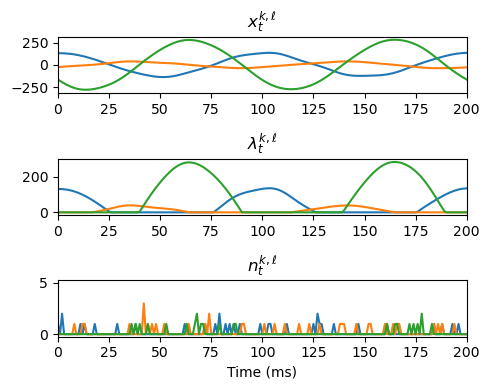

In [56]:
fig, ax = plt.subplots(3,1, figsize=(5,4))
k = 0
l = 0

s = 3
for l in range(s, s+3):
    ax[0].plot(xs[:,k,l])
    ax[0].set_title(r'$x^{k,\ell}_t$')
    ax[1].plot(lams[:,k,l])
    ax[1].set_title(r'$\lambda^{k,\ell}_t$')
    ax[2].plot(obs[:,k,l])
    ax[2].set_title(r'$n^{k,\ell}_t$')
    ax[2].set_xlabel('Time (ms)')

for i in range(3):
    ax[i].set_xlim([0,200])

plt.tight_layout()

In [35]:
def transform(spec, dB=True):
    if dB is True:
        return 10*jnp.log10(spec+1e-15)
    else:
        return spec

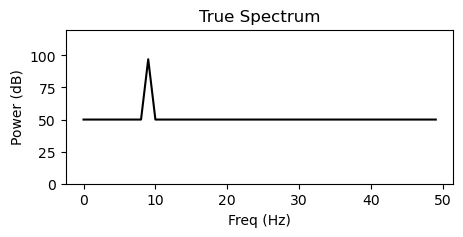

In [40]:
dB = True
fig, ax = plt.subplots(figsize=(5,2))
S_true = transform(gamma_full[nz,k,k].real, dB=dB)
ax.plot(S_true, color='k')
ax.set_title('True Spectrum')
ax.set_xlabel('Freq (Hz)')
if dB is True:
    ax.set_ylabel('Power (dB)')
    ax.set_ylim([0,120])
else:
    ax.set_ylabel('Power')

# plt.plot(gamma_est[:,k,k].real)
# plt.plot(gamma_init[:,k,k].real)
# plt.ylim([0,1e6])